<a href="https://colab.research.google.com/github/brendanfoo/predict_refugee_count/blob/main/Refining_Cont_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SUMMARY OF NOTEBOOK (AFTER SCALING IDPS):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
NN | Log IDPs | Categorical | 3 bins, same code as Brendan's | Accuracy = 0.474
NN | Log IDPs | Categorical | 2 bins | Accuracy = 0.663
NN | Log IDPs | Continuous | N/A | MAPE = 34.6%

**SUMMARY OF NOTEBOOK (BEFORE SCALING IDPs):**

Model | Specifications | Predict | Notes | Key Takeaways
------|----------------|---------|-------|---------------
NN | Log IDPs | Categorical | Split (3) bins on range, same code as Brendan's | Accuracy = 0.516
NN | Log IDPs | Continuous | N/A | MAPE = 44.66%

# Imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
import geopandas as gpd
import random
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Modelling
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import metrics

# plots
import seaborn as sns
import matplotlib.pyplot as plt
tf.get_logger().setLevel('INFO')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Imports and Log Transformation of IDP Column

In [ ]:
fullmerge = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/FULLMERGE.csv').iloc[:, 1:]
fullmerge.drop(columns = ['Ended'])
fullmerge.head()

,ISO3,IDPs from Event,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,...,Began,Ended,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",Scaled_IDP
0,AFG,270,0.178628,0.172592,0.335777,0.757451,0.507907,0.480512,0.580916,0.537736,...,2013-04-23,2013-04-29,Torrential Rain,1.0,6.0,11.384192,"31,098,161",47.7,"-67,219",270
1,AFG,740,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",740
2,AFG,244,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115",245
3,AFG,5775,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,2014-06-03,2014-06-10,Heavy Rain,1.5,7.0,13.047944,"31,809,829",48.8,"-58,115",5775
4,AFG,46380,0.210240,0.158260,0.354043,0.711203,0.509198,0.480512,0.615954,0.534952,...,2018-05-09,2018-05-22,Torrential Rain,1.5,13.0,15.095260,"34,907,481",53.5,"-21,703",46380


<Axes: ylabel='Density'>

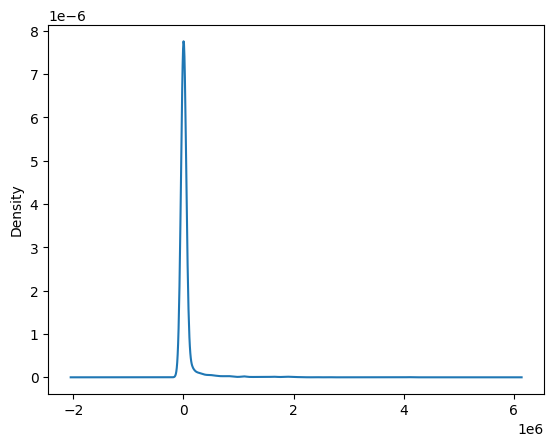

In [ ]:
nn_log_idps = fullmerge.dropna()

# plot distribution of 'IDPs from Event' column values
nn_log_idps['Scaled_IDP'].plot(kind = 'kde')

<ipython-input-5-c9c052668afd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nn_log_idps['log_idps'] = np.log(nn_log_idps['Scaled_IDP'])


<Axes: ylabel='Density'>

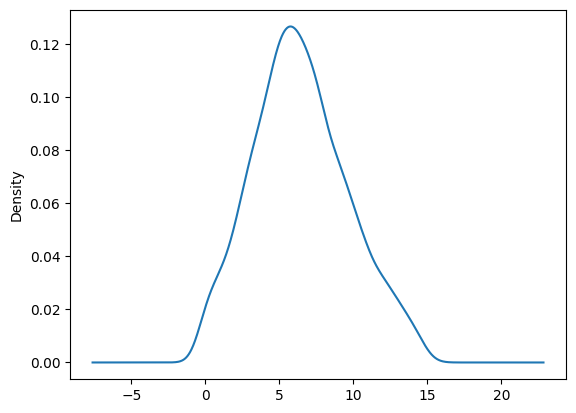

In [ ]:
nn_log_idps['log_idps'] = np.log(nn_log_idps['Scaled_IDP'])

# plot distribution of 'log_idps' column values
nn_log_idps['log_idps'].plot(kind = 'kde')

### Organizing Dataset

In [ ]:
cont_nn_log_idps = fullmerge.dropna()
cont_nn_log_idps['Scaled_IDP'].min() # 1

# Logging the minimum value of 'Scaled_IDP', 1, results in 0, which messes
# up the calculation of MAPE later on
# To fix this, I added 1 to all 'Scaled_IDP' values then took the log
cont_nn_log_idps['Scaled_IDP'] = cont_nn_log_idps['Scaled_IDP'] + 1
cont_nn_log_idps['log_idps'] = np.log(cont_nn_log_idps['Scaled_IDP'])

cont_nn_log_idps['Began'] = pd.to_datetime(cont_nn_log_idps['Began'])
month_ohe = pd.get_dummies(cont_nn_log_idps['Began'].dt.month, drop_first = True)

#iso_ohe = pd.get_dummies(cont_nn_log_idps['ISO3'], drop_first = True)

<ipython-input-6-a0a83d078a9c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_nn_log_idps['Scaled_IDP'] = cont_nn_log_idps['Scaled_IDP'] + 1
<ipython-input-6-a0a83d078a9c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_nn_log_idps['log_idps'] = np.log(cont_nn_log_idps['Scaled_IDP'])
<ipython-input-6-a0a83d078a9c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
cont_nn_log_idps['Scaled_IDP'].min()

2

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['ISO3', 'Began', 'Ended'])
cont_nn_log_idps = cont_nn_log_idps.join(month_ohe)
#cont_nn_log_idps = cont_nn_log_idps.join(iso_ohe)

cont_nn_log_idps['MainCause'] = cont_nn_log_idps['MainCause'].str.lower()

In [ ]:
cont_nn_log_idps['Storms'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['DamBreak'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['Rain'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['Melting'] = np.zeros(cont_nn_log_idps.shape[0])
cont_nn_log_idps['TidesTsunami'] = np.zeros(cont_nn_log_idps.shape[0])

In [ ]:
for index, row in cont_nn_log_idps.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    cont_nn_log_idps.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    cont_nn_log_idps.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    cont_nn_log_idps.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    cont_nn_log_idps.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    cont_nn_log_idps.loc[index, 'TidesTsunami'] = 1

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['MainCause'])

In [ ]:
for col in cont_nn_log_idps.columns:
  print(col, end=' | ')

IDPs from Event | Economics | Governance | Social | Capacity | Ecosystem | Exposure | Food | Habitat | Health | Infrastructure | Sensitivity | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | Scaled_IDP | log_idps | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | 

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.replace(',','', regex=True)
cont_nn_log_idps = cont_nn_log_idps.replace('--','0', regex=True)
cont_nn_log_idps.shape

(2622, 37)

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.dropna()
cont_nn_log_idps.shape

(2622, 37)

In [ ]:
# median = 500
# mean = 47,000
# std = 200,000
cont_nn_log_idps['Scaled_IDP'].describe()

count    2.622000e+03
mean     4.775032e+04
std      2.225334e+05
min      2.000000e+00
25%      6.900000e+01
50%      5.010000e+02
75%      5.039750e+03
max      4.095281e+06
Name: Scaled_IDP, dtype: float64

In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['IDPs from Event', 'Scaled_IDP', 'Area', 'Severity', 'Duration'])
cont_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,...,8,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0


In [ ]:
cont_nn_log_idps = cont_nn_log_idps.drop(columns = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
cont_nn_log_idps = cont_nn_log_idps.drop(columns = ['Storms', 'DamBreak', 'Rain', 'Melting', 'TidesTsunami'])
cont_nn_log_idps.head()

,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps
31,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,7.661998
32,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,7.493874
33,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,6.473891
34,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.279828,27292819,21.9,14473,6.304449
35,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,0.298719,0.273778,12.448232,27292819,21.9,14473,5.572154


In [ ]:
cont_nn_log_idps['log_idps'].min()

0.6931471805599453

In [ ]:
# taking log of infra and pops

cont_nn_log_idps['Population'] = pd.to_numeric(cont_nn_log_idps['Population'], errors='coerce')
cont_nn_log_idps['Population Density (People per Sq. Km.)'] = pd.to_numeric(cont_nn_log_idps['Population Density (People per Sq. Km.)'], errors='coerce')

cont_nn_log_idps['Infrastructure'] = np.log(cont_nn_log_idps['Infrastructure']).fillna(0)
cont_nn_log_idps['Population'] = np.log(cont_nn_log_idps['Population']).fillna(0)
cont_nn_log_idps['Population Density (People per Sq. Km.)'] = np.log(cont_nn_log_idps['Population Density (People per Sq. Km.)']).fillna(0)

### Model

Model is based on: https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/

In [ ]:
cont_nn_log_idps.columns

Index(['Economics', 'Governance', 'Social', 'Capacity', 'Ecosystem',
       'Exposure', 'Food', 'Habitat', 'Health', 'Infrastructure',
       'Sensitivity', 'Magnitude', 'Population',
       'Population Density (People per Sq. Km.)',
       'Net international migrants, both sexes', 'log_idps'],
      dtype='object')

In [ ]:
# Separate Target Variable and Predictor Variables
TargetVariable=['log_idps']
Predictors=['Economics', 'Governance', 'Social', 'Capacity', 'Ecosystem', 'Exposure', 'Food', 'Habitat', 'Health',
            'Infrastructure', 'Sensitivity', 'Magnitude', 'Population', 'Population Density (People per Sq. Km.)',
            'Net international migrants, both sexes']

X = cont_nn_log_idps[Predictors].values
y = cont_nn_log_idps[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2097, 15)
(2097, 1)
(525, 15)
(525, 1)


In [ ]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=15, input_dim=15, kernel_initializer='normal', activation='relu'))

# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))

# Defining the Third layer of the model
model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 10, epochs = 50, verbose=1)

Epoch 1/50
210/210 [==============================] - 1s 2ms/step - loss: 0.8959
Epoch 2/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8272
Epoch 3/50
210/210 [==============================] - 0s 2ms/step - loss: 0.8058
Epoch 4/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7919
Epoch 5/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7757
Epoch 6/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7642
Epoch 7/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7530
Epoch 8/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7510
Epoch 9/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7446
Epoch 10/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7404
Epoch 11/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7360
Epoch 12/50
210/210 [==============================] - 0s 2ms/step - loss: 0.7369
Epoch 13/50
210/210 [====

### Hyperparameter Tuning of ANN (commented)

In [ ]:
# # Finding best set of parameters using manual grid search

# # Defining a function to find the best parameters for ANN
# def FunctionFindBestParams(X_train, y_train, X_test, y_test):

#     # Defining the list of hyper parameters to try
#     batch_size_list=[5, 10, 15, 20]
#     epoch_list  =   [5, 10, 50, 100]

#     import pandas as pd
#     SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])

#     # initializing the trials
#     TrialNumber=0
#     for batch_size_trial in batch_size_list:
#         for epochs_trial in epoch_list:
#             TrialNumber+=1
#             # create ANN model
#             model = Sequential()
#             # Defining the first layer of the model
#             model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

#             # Defining the Second layer of the model
#             model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

#             # The output neuron is a single fully connected node
#             # Since we will be predicting a single number
#             model.add(Dense(1, kernel_initializer='normal'))

#             # Compiling the model
#             model.compile(loss='mean_squared_error', optimizer='adam')

#             # Fitting the ANN to the Training set
#             model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)

#             MAPE = np.mean(100 * (np.abs(y_test-model.predict(X_test))/y_test))

#             # printing the results of the current iteration
#             print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', 100-MAPE)

#             SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE]],
#                                                                     columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
#     return(SearchResultsData)


# ######################################################
# # Calling the function
# ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

In [ ]:
# ResultsData.plot(x='Parameters', y='Accuracy', figsize=(15,4), kind='line')

### Training the ANN Model with Best Parameters

In [ ]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train, batch_size = 15, epochs = 50, verbose=0) # batch size and epoch chosen in hyperparameter tuning above

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['log_idps']=y_test_orig
TestingData['pred_log_idps']=Predictions
TestingData.head()

17/17 [==============================] - 0s 2ms/step


,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps,pred_log_idps
0,0.643221,0.781837,0.663970,0.280019,0.469278,0.519501,0.246007,0.528106,0.226299,-0.838639,0.340670,13.171690,18.653500,5.847305,94438.0,5.905362,8.653871
1,0.676939,0.821446,0.599509,0.302669,0.372606,0.479702,0.362785,0.489519,0.227527,-1.921324,0.160552,12.548337,17.008871,1.163151,241770.0,3.465736,4.891527
2,0.273172,0.349983,0.230581,0.608792,0.431001,0.492328,0.519134,0.590062,0.426909,-0.883108,0.340419,10.991955,18.321326,5.716040,-246329.0,9.879707,8.727352
3,0.594974,0.472279,0.580677,0.439379,0.515650,0.448469,0.391348,0.433590,0.373881,-1.581832,0.266851,15.775487,21.062614,5.013963,0.0,13.576804,8.479929
4,0.618120,0.750582,0.647906,0.242141,0.423670,0.481034,0.348389,0.449201,0.174245,-1.818640,0.204079,13.204771,19.604976,3.575151,651793.0,5.342334,5.016584


### Model Accuracy

In [ ]:
# Computing the absolute percent error
APE=100*(abs(TestingData['log_idps']-TestingData['pred_log_idps'])/TestingData['log_idps'])
TestingData['APE']=APE

print('The absolute percent error of ANN model is:', 100-np.mean(APE))
TestingData.head()

The absolute percent error of ANN model is: 34.96089828510411


,Economics,Governance,Social,Capacity,Ecosystem,Exposure,Food,Habitat,Health,Infrastructure,Sensitivity,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",log_idps,pred_log_idps,APE
0,0.643221,0.781837,0.663970,0.280019,0.469278,0.519501,0.246007,0.528106,0.226299,-0.838639,0.340670,13.171690,18.653500,5.847305,94438.0,5.905362,8.653871,46.542596
1,0.676939,0.821446,0.599509,0.302669,0.372606,0.479702,0.362785,0.489519,0.227527,-1.921324,0.160552,12.548337,17.008871,1.163151,241770.0,3.465736,4.891527,41.139626
2,0.273172,0.349983,0.230581,0.608792,0.431001,0.492328,0.519134,0.590062,0.426909,-0.883108,0.340419,10.991955,18.321326,5.716040,-246329.0,9.879707,8.727352,11.663857
3,0.594974,0.472279,0.580677,0.439379,0.515650,0.448469,0.391348,0.433590,0.373881,-1.581832,0.266851,15.775487,21.062614,5.013963,0.0,13.576804,8.479929,37.541052
4,0.618120,0.750582,0.647906,0.242141,0.423670,0.481034,0.348389,0.449201,0.174245,-1.818640,0.204079,13.204771,19.604976,3.575151,651793.0,5.342334,5.016584,6.097528


In [ ]:
# Calculating the absolute differences between actual and predicted values
abs_diff = np.abs(np.exp(TestingData['log_idps']) - np.exp(TestingData['pred_log_idps']))

# Finding out the percentage of predictions within x IDP counts of the actual value
sig_error_margin = 5000
percentage_within_x = np.mean(abs_diff <= sig_error_margin) * 100
percentage_within_x

71.23809523809524

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(np.exp(TestingData['log_idps']), np.exp(TestingData['pred_log_idps'])))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared
r2 = r2_score(np.exp(TestingData['log_idps']),  np.exp(TestingData['pred_log_idps']))
print(f'R-squared (R^2): {r2}')


Root Mean Squared Error (RMSE): 167728.9958501508
R-squared (R^2): -0.020151733072813816


In [ ]:
max(np.exp(TestingData['pred_log_idps']))

85044.359375

Text(0, 0.5, 'Preds')

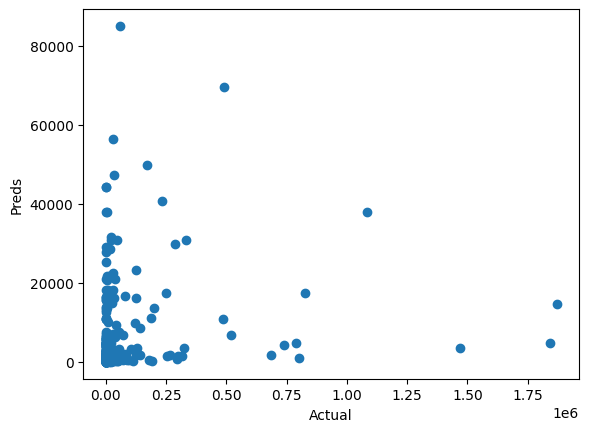

In [ ]:
plt.scatter(np.exp(TestingData['log_idps']), np.exp(TestingData['pred_log_idps']))
plt.xlabel('Actual')
plt.ylabel('Preds')